# Part 3: Truncation and GradientEstimator

In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
from matplotlib import pylab as plt

from learned_optimization.outer_trainers import full_es
from learned_optimization.outer_trainers import truncated_pes
from learned_optimization.outer_trainers import gradient_learner
from learned_optimization.outer_trainers import truncation_schedule

from learned_optimization.tasks import quadratics
from learned_optimization.tasks.fixed import image_mlp
from learned_optimization.tasks import base as tasks_base

from learned_optimization.learned_optimizers import base as lopt_base
from learned_optimization.learned_optimizers import mlp_lopt
from learned_optimization.optimizers import base as opt_base

from learned_optimization import optimizers
from learned_optimization import training
from learned_optimization import eval_training

import haiku as hk
import tqdm

## Training learned optimizers: Truncated training, and different kinds of gradient estimators.

In the the previous colabs we showed some of the core abstractions this library is based on: `Task`, `Optimizer`, `LearnedOptimizer`, and `TaskFamily`. We also showed a rather minimal meta-training procedure
which trains learned optimizers to perform well with a handful of inner-training steps.

In this colab, we will discuss meta-training more in detail and discuss some of the more heavy weight abstractions designed to facilitate meta-training.
This includes methods built on truncated backprop through time, evolutionary strategies, and persistent evolutionary strategies.

This will be divided into three main components: `TruncationSchedule` which define how truncated training works, `GradientEstimator` which often leverage truncations and estimate meta-gradients -- or gradients of the meta-loss with respect to the learned optimizer weights, and `GradientLearner` which take these gradients and manage updating the learned optimizer weights.

## Truncated training and TruncationSchedules

When applying a learned optimizer to train some target task, one usually wants the optimizer to be performant for a very large number of steps as training a model can take hundreds to hundreds of thousands of iterations.
Ideally we would like our meta-training procedure to mirror the testing setup but given how long these unrolls (iterative application of the learned optimizer) can be this can become challenging. Truncated training is one solution to this. The core idea is to never run an entire inner-problem to completion, but instead unroll a shorter segment, and leverage information from that shorter segment to update the weights of the learned optimizer.

This is most commonly seen in the form of truncated backpropogation through time and is used to train training recurrent neural networks. More recently, truncated training has been used to train RL algorithms (e.g. A3C).

Truncated training has a number of benifits. First, it greatly reduces the amount of computation needed before updating the learned optimizer. If one has length 100 truncations for a total length of 10k iterations, one 100x more updates to the weights of the learned optimizer. For some methods, like PES, we can even do these gradient estimates in an unbiased way (technically less biased, see PES paper for a discussion on hysteresis). For others, such as gradient based meta-training, and other ES variants, this comes at the cost of bias.

In code, truncations are handed by a TruncationSchedule subclass which is a small, stateless classes which manage how long we should be computing training for. For example, here we see a constant length truncation which runs for 10 steps then reports done.

In [5]:
trunc_sched = truncation_schedule.ConstantTruncationSchedule(10)
outer_state = None
key = jax.random.PRNGKey(0)
trunc_state = trunc_sched.init(key, outer_state)
for i in range(12):
  trunc_state, is_done = trunc_sched.next_state(trunc_state, i, key,
                                                outer_state)
  print(i, is_done)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 True
11 True


In practice, we often run these sequentially.

For example, here is a loop which let's us sequentially train a model over and over again.
To do this, we must keep track of some state which progresses from inner-iteration to
inner-iteration. In this case, this is the problem we are training's opt_state, the
state of the truncation, and a rng key.

In [6]:
key = jax.random.PRNGKey(0)
task = image_mlp.ImageMLP_FashionMnist8_Relu32()
opt = opt_base.Adam(3e-3)
outer_state = None


def init_state(key):
  key, key1, key2 = jax.random.split(key, 3)
  p = task.init(key1)
  opt_state = opt.init(p)

  trunc_sched = truncation_schedule.ConstantTruncationSchedule(50)
  trunc_state = trunc_sched.init(key2, outer_state)

  return opt_state, trunc_state, key


def next_trunc_and_train(train_state_and_batch):
  (opt_state, trunc_state, key), batch = train_state_and_batch
  # progress one step on the truncation state
  trunc_state, is_done = trunc_sched.next_state(trunc_state,
                                                opt_state.iteration, key,
                                                outer_state)

  # progress one step on the
  p = opt.get_params(opt_state)
  key, key1 = jax.random.split(key)
  l, g = jax.value_and_grad(task.loss)(p, key1, batch)
  opt_state = opt.update(opt_state, g, loss=l)

  return (opt_state, trunc_state, key), is_done, l


def reset_trunc_and_init(train_state_and_batch):
  (opt_state, trunc_state, key), batch = train_state_and_batch

  # new inner problem
  p = task.init(key)
  opt_state = opt.init(p)

  # new truncation
  key, key1 = jax.random.split(key)
  trunc_state = trunc_sched.init(key1, outer_state)

  return (opt_state, trunc_state, key), False, jnp.nan


is_done = False
state = init_state(key)

losses = []
for i in range(200):
  batch = next(task.datasets.train)
  state, is_done, loss = jax.lax.cond(is_done, reset_trunc_and_init,
                                      next_trunc_and_train, (state, batch))
  losses.append(loss)

Now we can plot the losses. We see a sequence of decreasing losses, which get reset back to initialization every 25 steps.

Text(0, 0.5, 'loss')

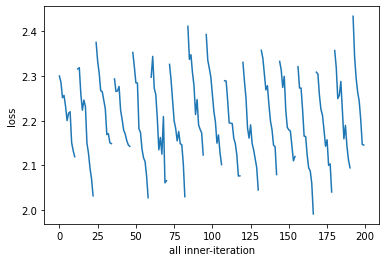

In [7]:
plt.plot(losses)
plt.xlabel("all inner-iteration")
plt.ylabel("loss")

One key reason why this abstraction is important is when thinking about training multiple models in parallel. Naively, we could train all models starting from initialization with the exact same iteration into training.
This is sometimes refered to as "lock step" training.

One alternative is to break this lock-steping, and let our models train different parts of the inner-problem at different times.
With this TruncationState abstraction we can do this by either training with variable length unrolls, or faking the initial state so models reset early.

For starters, we can see training multiple models with lock step unrolls:

In [8]:
n_tasks = 8


@jax.jit
@jax.vmap
def update(state, is_done, batch):
  state, is_done, loss = jax.lax.cond(is_done, reset_trunc_and_init,
                                      next_trunc_and_train, (state, batch))
  return state, is_done, loss


keys = jax.random.split(key, n_tasks)
states = jax.vmap(init_state)(keys)

losses = []
is_done = jnp.zeros([n_tasks])
for i in range(200):
  vec_batch = training.vec_get_batch(task, n_tasks)
  states, is_done, l = update(states, is_done, vec_batch)
  losses.append(l)

Text(0, 0.5, 'loss')

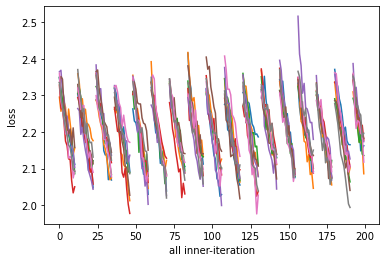

In [9]:
losses = np.asarray(losses)
for i in range(n_tasks):
  plt.plot(losses[:, i])

plt.xlabel("all inner-iteration")
plt.ylabel("loss")

And then, we can compare this to what the curves look like if we break the lockstep by simply faking the initial iteration.

In [10]:
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, n_tasks)
states = jax.vmap(init_state)(keys)
opt_state, trunc_state, keys = states
import dataclasses

opt_state = opt_state._replace(
    iteration=jax.random.randint(key, [n_tasks], 0, 50))
states = (opt_state, trunc_state, keys)

losses = []
is_done = jnp.zeros([n_tasks])
for i in range(200):
  vec_batch = training.vec_get_batch(task, n_tasks)
  states, is_done, l = update(states, is_done, vec_batch)
  losses.append(l)

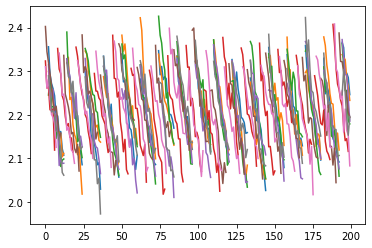

In [11]:
losses = np.asarray(losses)
for i in range(n_tasks):
  plt.plot(losses[:, i])

With this version, all the tasks start lockstep-ed initially, but then reset early so as to ensure the training trajectories are not running in lock step.

## GradientEstimators

Gradient estimators provide an interface to estimate gradients of some loss with respect to the parameters of the learned optimizer.

`learned_optimization` supports a handfull of estimators each with different strengths and weaknesses. Understanding which estimators are right for which situations is an open research question. After providing some introductions to the GradientEstimator class, we provide a quick tour of the different estimators implemented here.


All optimizers discussed here operate on a `TaskFamily` and meta-train with multiple task samples in parallel.


The `GradientEstimator` base class signature is below.

In [12]:
from typing import Optional, Tuple, Mapping
from learned_optimization.tasks import base as tasks_base
from learned_optimization.learned_optimizers import base as lopt_base
from learned_optimization.outer_trainers.gradient_learner import WorkerWeights, GradientEstimatorState, GradientEstimatorOut

PRNGKey = jnp.ndarray


class GradientEstimator:
  task_family: tasks_base.TaskFamily
  learned_opt: lopt_base.LearnedOptimizer

  def init_worker_state(self, worker_weights: WorkerWeights,
                        key: PRNGKey) -> GradientEstimatorState:
    raise NotImplementedError()

  def compute_gradient_estimate(
      self, worker_weights: WorkerWeights, key: PRNGKey,
      state: GradientEstimatorState, with_summary: Optional[bool]
  ) -> Tuple[GradientEstimatorOut, Mapping[str, jnp.ndarray]]:
    raise NotImplementedError()

A gradient estimator must have an instance of a TaskFamily -- or the task that is being used to estimate gradients with, an `init_worker_state` function -- which initializes the current state of the gradient estimator, and a `compute_gradient_estimate` function which takes state and computes a bunch of outputs (`GradientEstimatorOut`) which contain the computed gradients with respect to the learned optimizer, meta-loss values, and various other information about the unroll. Additionally a mapping which contains various metrics is returned.

Both of these methods take in a `WorkerWeights` instance. This particular piece of data represents the learnable weights needed to compute a gradients. In every case this contains the weights of the learned optimizer (often called theta), but it can also contain some other state. For example if the learned optimizer has batchnorm it could also contain running averages.

### FullES

The FullES estimator is one of the simplest, and most reliable estimator but can be slow in practice as it does not make use of truncations. Instead, it uses antithetic sampling to estimate a gradient via ES of an entire optimization (hense the full in the name).

First we define a meta-objective, $f(\theta)$, which could be the loss at the end of training, or average loss. Next, we compute a gradient estimate via ES gradient estimation:

$\nabla_\theta f \approx \dfrac{\epsilon}{2\sigma^2} ((\theta + \epsilon) - f(\theta - \epsilon))$

We can instantiate one of these as follows:

In [13]:
task_family = quadratics.FixedDimQuadraticFamily(10)
lopt = lopt_base.LearnableAdam()
max_length = 1000

gradient_estimator = full_es.FullES(
    task_family=task_family, learned_opt=lopt, num_tasks=4, unroll_length=100)

In [14]:
key = jax.random.PRNGKey(0)
theta = lopt.init(key)
worker_weights = gradient_learner.WorkerWeights(
    theta=theta,
    theta_model_state=None,
    outer_state=gradient_learner.OuterState(0))

Because we are working with full lenght unrolls, this gradient estimator has no state -- there is nothing to keep track of truncation to truncation.

In [15]:
gradient_estimator_state = gradient_estimator.init_worker_state(
    worker_weights, key=key)
gradient_estimator_state

UnrollState()

Gradients can be computed with the `compute_gradient_estimate` method.

In [16]:
out, metrics = gradient_estimator.compute_gradient_estimate(
    worker_weights, key=key, state=gradient_estimator_state, with_summary=False)

In [17]:
out.grad

{'log_epsilon': DeviceArray(0.6246758, dtype=float32),
 'log_lr': DeviceArray(-1.3742474, dtype=float32),
 'one_minus_beta1': DeviceArray(0.8555549, dtype=float32),
 'one_minus_beta2': DeviceArray(1.141762, dtype=float32)}

### TruncatedPES

Truncated Persistent Evolutionary Strategies (PES) is a unbiased truncation method based on ES. It was proposed in [Unbiased Gradient Estimation in Unrolled Computation Graphs with Persistent Evolution Strategies](https://arxiv.org/abs/2112.13835) and has been a promising tool for training learned optimizers.

In [18]:
task_family = quadratics.FixedDimQuadraticFamily(10)
lopt = lopt_base.LearnableAdam()
max_length = 1000
trunc_sched = truncation_schedule.LogUniformLengthSchedule(
    min_length=100, max_length=max_length)

gradient_estimator = truncated_pes.TruncatedPES(
    task_family=task_family,
    learned_opt=lopt,
    trunc_sched=trunc_sched,
    num_tasks=4,
    trunc_length=50,
    random_initial_iteration_offset=max_length)

In [19]:
key = jax.random.PRNGKey(0)
theta = lopt.init(key)
worker_weights = gradient_learner.WorkerWeights(
    theta=theta,
    theta_model_state=None,
    outer_state=gradient_learner.OuterState(0))

In [20]:
gradient_estimator_state = gradient_estimator.init_worker_state(
    worker_weights, key=key)

Now let's look at what this state contains.

In [21]:
jax.tree_map(lambda x: x.shape, gradient_estimator_state)

PESWorkerState(pos_state=TruncatedUnrollState(inner_opt_state=OptaxState(params=(4, 10), state=None, optax_opt_state=(ScaleByAdamState(count=(4,), mu=(4, 10), nu=(4, 10)), EmptyState()), iteration=(4,)), inner_step=(4,), truncation_state=ConstantTruncationState(length=(4,)), task_param=(4, 10), is_done=(4,)), neg_state=TruncatedUnrollState(inner_opt_state=OptaxState(params=(4, 10), state=None, optax_opt_state=(ScaleByAdamState(count=(4,), mu=(4, 10), nu=(4, 10)), EmptyState()), iteration=(4,)), inner_step=(4,), truncation_state=ConstantTruncationState(length=(4,)), task_param=(4, 10), is_done=(4,)), accumulator={'log_epsilon': (4,), 'log_lr': (4,), 'one_minus_beta1': (4,), 'one_minus_beta2': (4,)})

First, this contains 2 instances of SingleState -- one for the positive perturbation, and one for the negative perturbation. Each one of these contains all the necessary state required to keep track of the training run. This means the opt_state, details from the truncation, the task parameters (sample from the task family), the inner_step, and a bool to determine if done or not.

We can compute one gradient estimate as follows.

In [22]:
out, metrics = gradient_estimator.compute_gradient_estimate(
    worker_weights, key=key, state=gradient_estimator_state, with_summary=False)

This `out` object contains various outputs from the gradient estimator including gradients with respect to the learned optimizer, as well as the next state of the training models.

In [23]:
out.grad

{'log_epsilon': DeviceArray(0.24771774, dtype=float32),
 'log_lr': DeviceArray(-0.5622769, dtype=float32),
 'one_minus_beta1': DeviceArray(0.3309788, dtype=float32),
 'one_minus_beta2': DeviceArray(0.5197946, dtype=float32)}

In [24]:
jax.tree_map(lambda x: x.shape, out.unroll_state)

PESWorkerState(pos_state=TruncatedUnrollState(inner_opt_state=OptaxState(params=(4, 10), state=None, optax_opt_state=(ScaleByAdamState(count=(4,), mu=(4, 10), nu=(4, 10)), EmptyState()), iteration=(4,)), inner_step=(4,), truncation_state=ConstantTruncationState(length=(4,)), task_param=(4, 10), is_done=(4,)), neg_state=TruncatedUnrollState(inner_opt_state=OptaxState(params=(4, 10), state=None, optax_opt_state=(ScaleByAdamState(count=(4,), mu=(4, 10), nu=(4, 10)), EmptyState()), iteration=(4,)), inner_step=(4,), truncation_state=ConstantTruncationState(length=(4,)), task_param=(4, 10), is_done=(4,)), accumulator={'log_epsilon': (4,), 'log_lr': (4,), 'one_minus_beta1': (4,), 'one_minus_beta2': (4,)})

One could simply use these gradients to meta-train, and then use the unroll_states as the next state passed into the compute gradient estimate. For example:

In [25]:
print("Progress on inner problem before", out.unroll_state.pos_state.inner_step)
out, metrics = gradient_estimator.compute_gradient_estimate(
    worker_weights, key=key, state=out.unroll_state, with_summary=False)
print("Progress on inner problem after", out.unroll_state.pos_state.inner_step)

Progress on inner problem before [48 95 48 48]
Progress on inner problem after [ 98 145  98  98]


We can see that for each problem we progress 50 steps (or reset and start over from scratch).